# Testing PID controller

This notebook shows how to test and tune PID controller. 


* The PID controller has to be implemented in [pid.py](./pid.py) first;
* Make sure ipywidgets is enabled with command: 
    ```sh
    jupyter nbextension enable --py widgetsnbextension
    ```
    read more in [ipywidgets wiki](https://github.com/jupyter-widgets/ipywidgets/blob/master/README.md#install)

In [1]:
## Initial Setup and Imports (Cell 1)
%matplotlib widget 
from matplotlib import pylab as plt
from ipywidgets import interact
from IPython import display
from collections import deque

## start simspark
Start SimSpark simulator as described in [last lecture](../introduction/README.md)

## run PIDAgent
Run all code below, there is plot show current joint angle and desired joint angle.

You can set target value and tune the PID parameters to get better results. 


In [2]:
from pid import PIDAgent
agent = PIDAgent()

In [3]:
## Interactive Controls (Cell 3 - Corrected Layout Logic)
from ipywidgets import VBox, HBox, Layout, FloatSlider, IntSlider, Dropdown, interactive_output, interactive
from IPython.display import display

# --- 1. Define the PID Parameter Sliders and Function ---

# Define the individual slider widgets
kp_slider = FloatSlider(min=0, max=100, step=1, value=50, description='Kp')
ki_slider = FloatSlider(min=-1, max=1, step=0.1, value=0.0, description='Ki')
kd_slider = FloatSlider(min=-1, max=1, step=0.1, value=0.0, description='Kd')
delay_slider = IntSlider(min=0, max=5, step=1, value=0, description='Delay')

def set_pid_parameters_func(kp, ki, kd, delay):
    global agent
    agent.joint_controller.Kp = kp
    agent.joint_controller.Ki = ki
    agent.joint_controller.Kd = kd
    agent.joint_controller.set_delay(delay)

# Link the function to the widgets (we don't need the output widget itself)
interactive_output(
    set_pid_parameters_func,
    {'kp': kp_slider, 'ki': ki_slider, 'kd': kd_slider, 'delay': delay_slider}
)


# --- 2. Define the Joint Selector and Target Sliders ---

joint_name = 'HeadYaw'
sensor = deque(maxlen=100)
target = deque(maxlen=100)

joint_dropdown = Dropdown(options=agent.joint_names, value='HeadYaw', description='Joint Name')
target_slider = FloatSlider(min=-1, max=1, step=0.1, value=0.0, description='Target Value')

def set_joint_name_func(name):
    global joint_name
    if joint_name != name:
        joint_name = name
        sensor.clear()
        target.clear()
        # FIX: Reset the target for the newly selected joint
        agent.target_joints[joint_name] = 0.0

def set_joint_target_func(value):
    agent.target_joints[joint_name] = value

# Link functions to the widgets
interactive_output(set_joint_name_func, {'name': joint_dropdown})
interactive_output(set_joint_target_func, {'value': target_slider})


# --- 3. Create the Slider Display Box ---

# Collect all control widgets
control_widgets = [
    joint_dropdown,
    target_slider,
    kp_slider,
    ki_slider,
    kd_slider,
    delay_slider
]

# Combine all control widgets into a vertical box
control_panel = VBox(control_widgets, layout=Layout(width='40%')) # Constrain width for HBox
# IMPORTANT: Do NOT call display(control_panel) yet.

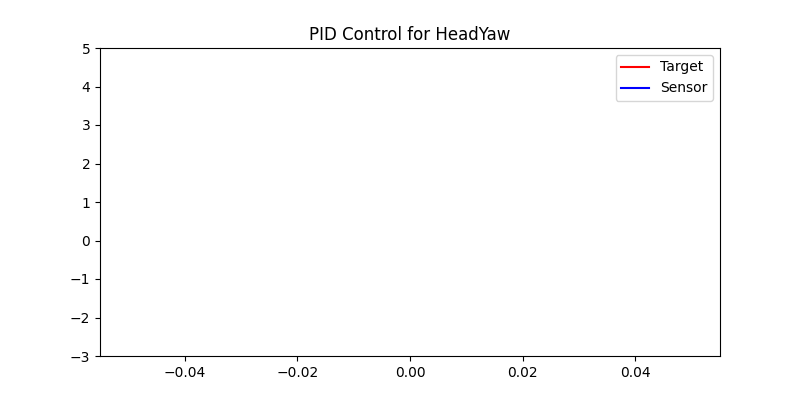

In [4]:
## Agent Loop and Plotting (Cell 4 - Final Integration)
# inject plotting input agent's loop
cycle = 0
orig_sense_think_act = agent.sense_think_act

# 1. Initialize Plot Elements ONCE before the loop
fig, ax = plt.subplots(figsize=(8, 4)) # Adjusted size for HBox display
target_line, = ax.plot([], [], '-r', label='Target')
sensor_line, = ax.plot([], [], '-b', label='Sensor')
ax.legend()
ax.set_title(f'PID Control for {joint_name}')
ax.set_ylim(-3, 5) 

# 2. Get the figure's canvas widget
plot_widget = fig.canvas
plot_widget.layout = Layout(height='1200px', width='99%') # <-- Ensure the widget container is large

# 3. Use HBox to display the Control Panel and the Plot side-by-side
# The control_panel variable is from the previous cell
display(VBox([
    control_panel,
    plot_widget
], layout=Layout(align_items='flex-start', width='100%', height='100%'))) 

def sense_think_act():
    global cycle
    cycle += 1
    orig_sense_think_act()
    
    # Update deques
    sensor.append(agent.perception.joint[joint_name])
    target.append(agent.target_joints[joint_name])
    
    if cycle % 10 == 0:  # Plot every 10 cycles
        # Update the line data 
        x_data = range(len(target))
        target_line.set_data(x_data, target)
        sensor_line.set_data(x_data, sensor)

        # Update x-axis limits dynamically
        ax.set_xlim(max(0, len(x_data) - 100), len(x_data))
        ax.set_title(f'PID Control for {joint_name}')
        
        # Request a redraw 
        fig.canvas.draw_idle()
        
agent.sense_think_act = sense_think_act
agent.start()